<a href="https://colab.research.google.com/github/imnbid/MachinLearning2025/blob/main/mini-project-3/Q5%26Q6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!gdown 1DJCskOn9K0Z31INtMdec4K2Jt9r-vQND

Downloading...
From: https://drive.google.com/uc?id=1DJCskOn9K0Z31INtMdec4K2Jt9r-vQND
To: /content/train.csv
100% 61.2k/61.2k [00:00<00:00, 4.08MB/s]


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# -------------------------
# 1) بارگذاری داده
# -------------------------
df = pd.read_csv("/content/train.csv")

# یک نگاه سریع برای اطمینان
print("Shape of raw data:", df.shape)
print(df.head())

# -------------------------
# 2) پر کردن مقادیر گمشده
# -------------------------
# Age: میانه
df["Age"] = df["Age"].fillna(df["Age"].median())

# Fare: میانه (حتی اگر در train کمتر خالی باشد، استاندارد است)
df["Fare"] = df["Fare"].fillna(df["Fare"].median())

# Embarked: مد (پرتکرارترین مقدار)
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

# -------------------------
# 3) حذف ستون‌های غیرقابل استفاده
# -------------------------
cols_to_drop = ["Ticket", "Name", "Cabin"]
df = df.drop(columns=cols_to_drop)

# -------------------------
# 4) تبدیل ویژگی‌های دسته‌ای به عددی با One-Hot Encoding
# -------------------------
# ستون‌های دسته‌ای مهم در این دیتاست: Sex, Embarked
# drop_first=False یعنی همه دسته‌ها نگه داشته می‌شود (برای فهم ساده‌تر)
df_encoded = pd.get_dummies(df, columns=["Sex", "Embarked"], drop_first=False)

print("Shape after encoding:", df_encoded.shape)

# -------------------------
# 5) جدا کردن X و y
# -------------------------
y = df_encoded["Survived"]          # برچسب/هدف
X = df_encoded.drop(columns=["Survived"])

# -------------------------
# 6) تقسیم Train/Test با نسبت 80/20
# -------------------------
# stratify=y باعث می‌شود نسبت کلاس‌ها (زنده/فوت) در train و test مشابه بماند
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Shape of raw data: (891, 12)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450

In [7]:
from sklearn.tree import DecisionTreeClassifier

# -------------------------
# 1) ساخت و آموزش مدل
# -------------------------
dt = DecisionTreeClassifier(
    max_depth=4,
    random_state=42
)

dt.fit(X_train, y_train)

# -------------------------
# 2) گزارش دقت روی Train و Test
# -------------------------
train_acc = dt.score(X_train, y_train)
test_acc = dt.score(X_test, y_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test  Accuracy: {test_acc:.4f}")

# -------------------------
# 3) چاپ تعداد گره‌ها و عمق واقعی درخت
# -------------------------
# تعداد گره‌ها:
num_nodes = dt.tree_.node_count

# عمق واقعی (ممکن است <= 4 باشد)
tree_depth = dt.tree_.max_depth

print("Number of nodes:", num_nodes)
print("Tree depth:", tree_depth)


Train Accuracy: 0.8413
Test  Accuracy: 0.7821
Number of nodes: 29
Tree depth: 4


In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt


# -------------------------------------------------------
# تابع 1: بارگذاری و آماده‌سازی داده‌ها + تقسیم Train/Test
# -------------------------------------------------------
def load_and_split_data(path="train.csv", test_size=0.2, random_state=42):
    df = pd.read_csv(path)

    # ستون‌های غیرقابل استفاده طبق صورت سوال
    df = df.drop(columns=["Ticket", "Name", "Cabin"])

    # جدا کردن ویژگی‌ها و برچسب هدف
    y = df["Survived"]
    X = df.drop(columns=["Survived"])

    # تقسیم 80/20 + حفظ نسبت کلاس‌ها
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    return X_train, X_test, y_train, y_test


# -------------------------------------------------------
# تابع 2: ساخت Pipeline پیش‌پردازش + مدل درخت تصمیم
# -------------------------------------------------------
def build_tree_pipeline(max_depth):
    # ستون‌ها را از نوع داده تشخیص می‌دهیم
    # (ساده و قابل فهم: عددی‌ها و دسته‌ای‌ها)
    numeric_features = ["Age", "Fare", "Pclass", "SibSp", "Parch", "PassengerId"]
    categorical_features = ["Sex", "Embarked"]

    # پیش‌پردازش عددی: پر کردن Missing با median
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median"))
    ])

    # پیش‌پردازش دسته‌ای: پر کردن Missing با mode + OneHot
    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    # ترکیب این دو بخش
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features)
        ]
    )

    # مدل درخت تصمیم
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)

    # کل پایپلاین (اول پیش‌پردازش، بعد مدل)
    clf = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])
    return clf


# -------------------------------------------------------
# تابع 3: آموزش و ارزیابی + استخراج عمق و تعداد گره
# -------------------------------------------------------
def train_evaluate_tree(X_train, y_train, X_test, y_test, max_depth):
    clf = build_tree_pipeline(max_depth=max_depth)
    clf.fit(X_train, y_train)

    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)

    # دسترسی به خود مدل درخت (داخل Pipeline)
    tree_model = clf.named_steps["model"]
    node_count = tree_model.tree_.node_count
    depth = tree_model.tree_.max_depth

    return {
        "max_depth": max_depth,
        "train_acc": train_acc,
        "test_acc": test_acc,
        "node_count": node_count,
        "tree_depth": depth,
        "pipeline": clf
    }


# ---------------------
# اجرای اصلی برنامه
# ---------------------
X_train, X_test, y_train, y_test = load_and_split_data("train.csv")


# =======================================================
# بخش (الف): درخت کامل (max_depth=None)
# =======================================================
full_result = train_evaluate_tree(X_train, y_train, X_test, y_test, max_depth=None)

print("=== Full Tree (max_depth=None) ===")
print(f"Train Accuracy: {full_result['train_acc']:.4f}")
print(f"Test  Accuracy: {full_result['test_acc']:.4f}")
print("Number of nodes:", full_result["node_count"])
print("Tree depth:", full_result["tree_depth"])
print()


# (برای مقایسه با مدل کم‌عمق قبلی: max_depth=4)
shallow_result = train_evaluate_tree(X_train, y_train, X_test, y_test, max_depth=4)

print("=== Shallow Tree (max_depth=4) [for comparison] ===")
print(f"Train Accuracy: {shallow_result['train_acc']:.4f}")
print(f"Test  Accuracy: {shallow_result['test_acc']:.4f}")
print("Number of nodes:", shallow_result["node_count"])
print("Tree depth:", shallow_result["tree_depth"])
print()

=== Full Tree (max_depth=None) ===
Train Accuracy: 1.0000
Test  Accuracy: 0.7151
Number of nodes: 269
Tree depth: 25

=== Shallow Tree (max_depth=4) [for comparison] ===
Train Accuracy: 0.8413
Test  Accuracy: 0.7765
Number of nodes: 29
Tree depth: 4



=== Results for different max_depth ===
 max_depth  train_acc  test_acc  node_count  tree_depth
       3.0   0.832865  0.782123          15           3
       5.0   0.856742  0.731844          47           5
      10.0   0.935393  0.776536         153          10
       NaN   1.000000  0.715084         269          25



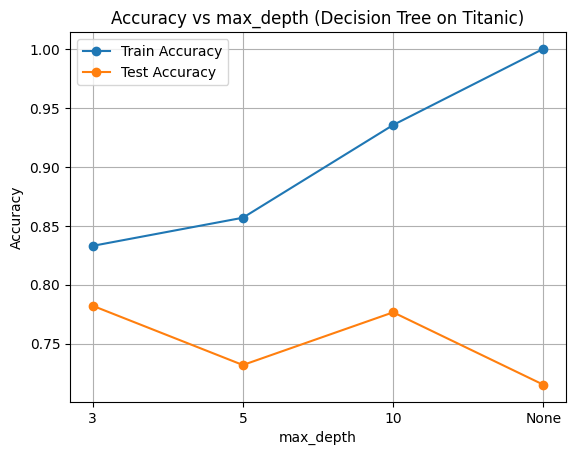

In [9]:
# بخش (ب): بررسی عمق‌های مختلف
# =======================================================
depths = [3, 5, 10, None]
results = []

for d in depths:
    res = train_evaluate_tree(X_train, y_train, X_test, y_test, max_depth=d)
    results.append(res)

# ساخت جدول نتایج (بدون ستون pipeline)
table_rows = []
for r in results:
    table_rows.append({
        "max_depth": r["max_depth"],
        "train_acc": r["train_acc"],
        "test_acc": r["test_acc"],
        "node_count": r["node_count"],
        "tree_depth": r["tree_depth"]
    })

df_results = pd.DataFrame(table_rows)
print("=== Results for different max_depth ===")
print(df_results.to_string(index=False))
print()


# رسم نمودار دقت آموزش و آزمون نسبت به max_depth
x = np.arange(len(depths))
train_accs = [r["train_acc"] for r in results]
test_accs = [r["test_acc"] for r in results]

plt.figure()
plt.plot(x, train_accs, marker="o", label="Train Accuracy")
plt.plot(x, test_accs, marker="o", label="Test Accuracy")
plt.xticks(x, ["3", "5", "10", "None"])
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs max_depth (Decision Tree on Titanic)")
plt.legend()
plt.grid(True)
plt.show()

=== Full Tree (Unpruned) ===
Train Accuracy: 1.0000
Test  Accuracy: 0.7151
Nodes: 269
Depth: 25

Number of positive alphas: 47
Smallest positive alpha: 0.0008192883895131086
Largest  positive alpha: 0.14259770698334534

=== First 10 pruning results ===
 ccp_alpha  train_acc  test_acc  nodes  depth
  0.000819   0.998596  0.715084    263     25
  0.000913   0.997191  0.715084    257     25
  0.000925   0.995787  0.720670    251     25
  0.001053   0.994382  0.720670    247     25
  0.001092   0.991573  0.720670    239     25
  0.001124   0.990169  0.720670    235     25
  0.001170   0.988764  0.720670    231     25
  0.001204   0.984551  0.720670    223     21
  0.001204   0.981742  0.720670    215     21
  0.001296   0.976124  0.720670    199     21



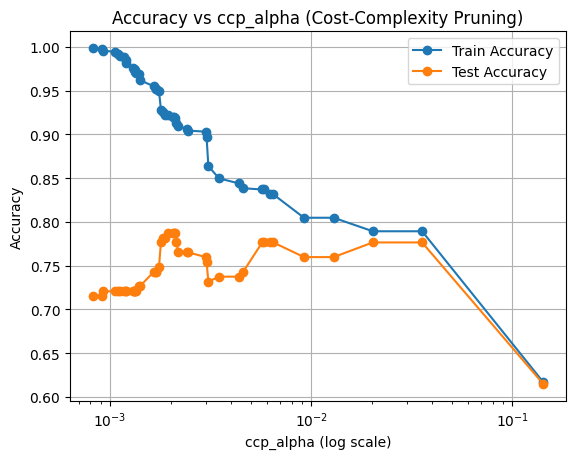

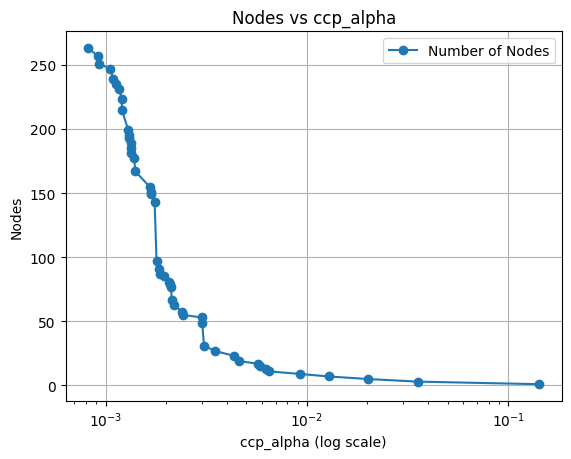

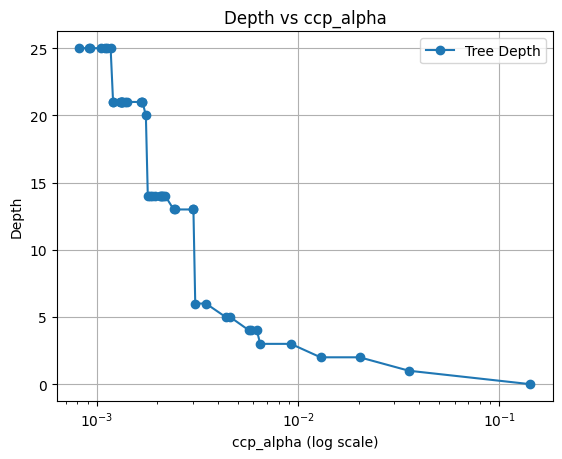

Chosen alpha (smallest candidate): 0.0017518424549957709

=== Pruned Tree (Chosen ccp_alpha) ===
ccp_alpha: 0.0017518424549957709
Train Accuracy: 0.9494
Test  Accuracy: 0.7486
Nodes: 143 (reduction 46.8%)
Depth: 20 (reduction 20.0%)

=== Shallow Tree (max_depth=4) ===
Train Accuracy: 0.8413
Test  Accuracy: 0.7765
Nodes: 29
Depth: 4


In [10]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt


# -------------------------
# 1) بارگذاری + تقسیم
# -------------------------
def load_and_split_data(path="train.csv", test_size=0.2, random_state=42):
    df = pd.read_csv(path)

    # حذف ستون‌های گفته‌شده در صورت سوال
    df = df.drop(columns=["Ticket", "Name", "Cabin"])

    y = df["Survived"]
    X = df.drop(columns=["Survived"])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    return X_train, X_test, y_train, y_test


# -------------------------
# 2) ساخت پیش‌پردازش (مثل قبل)
# -------------------------
def build_preprocessor():
    numeric_features = ["Age", "Fare", "Pclass", "SibSp", "Parch", "PassengerId"]
    categorical_features = ["Sex", "Embarked"]

    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median"))
    ])

    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features)
        ]
    )
    return preprocessor


# -------------------------
# 3) آموزش/ارزیابی یک درخت (با alpha مشخص)
# -------------------------
def fit_eval_tree(X_train_t, y_train, X_test_t, y_test, ccp_alpha=0.0, max_depth=None):
    clf = DecisionTreeClassifier(
        random_state=42,
        max_depth=max_depth,
        ccp_alpha=ccp_alpha
    )
    clf.fit(X_train_t, y_train)

    train_acc = clf.score(X_train_t, y_train)
    test_acc = clf.score(X_test_t, y_test)

    node_count = clf.tree_.node_count
    depth = clf.tree_.max_depth

    return clf, train_acc, test_acc, node_count, depth


# -------------------------
# اجرای اصلی
# -------------------------
X_train, X_test, y_train, y_test = load_and_split_data("train.csv")

# پیش‌پردازش را فقط روی Train فیت می‌کنیم (استاندارد و علمی‌تر)
preprocessor = build_preprocessor()
X_train_t = preprocessor.fit_transform(X_train)
X_test_t = preprocessor.transform(X_test)

# (i) درخت کامل بدون هرس (مرجع برای مقایسه)
full_tree, full_train_acc, full_test_acc, full_nodes, full_depth = fit_eval_tree(
    X_train_t, y_train, X_test_t, y_test,
    ccp_alpha=0.0,
    max_depth=None
)

print("=== Full Tree (Unpruned) ===")
print(f"Train Accuracy: {full_train_acc:.4f}")
print(f"Test  Accuracy: {full_test_acc:.4f}")
print("Nodes:", full_nodes)
print("Depth:", full_depth)
print()

# -------------------------
# 4) محاسبه مسیر هرس: cost_complexity_pruning_path
# -------------------------
path = full_tree.cost_complexity_pruning_path(X_train_t, y_train)
ccp_alphas = path.ccp_alphas

# فقط alphaهای مثبت (صفر حذف شود)
ccp_alphas_pos = ccp_alphas[ccp_alphas > 0]

# برای جلوگیری از تکراری‌ها (گاهی alpha ها نزدیک/تکراری می‌شوند)
ccp_alphas_pos = np.unique(ccp_alphas_pos)

print("Number of positive alphas:", len(ccp_alphas_pos))
print("Smallest positive alpha:", ccp_alphas_pos.min() if len(ccp_alphas_pos) else None)
print("Largest  positive alpha:", ccp_alphas_pos.max() if len(ccp_alphas_pos) else None)
print()

# -------------------------
# 5) آموزش مدل برای هر ccp_alpha و ذخیره نتایج
# -------------------------
results = []
for a in ccp_alphas_pos:
    clf, tr_acc, te_acc, nodes, depth = fit_eval_tree(
        X_train_t, y_train, X_test_t, y_test,
        ccp_alpha=float(a),
        max_depth=None
    )
    results.append({
        "ccp_alpha": float(a),
        "train_acc": tr_acc,
        "test_acc": te_acc,
        "nodes": nodes,
        "depth": depth
    })

res_df = pd.DataFrame(results).sort_values("ccp_alpha")
print("=== First 10 pruning results ===")
print(res_df.head(10).to_string(index=False))
print()

# -------------------------
# 6) رسم دقت‌ها بر حسب alpha (محور لگاریتمی)
# -------------------------
plt.figure()
plt.plot(res_df["ccp_alpha"], res_df["train_acc"], marker="o", label="Train Accuracy")
plt.plot(res_df["ccp_alpha"], res_df["test_acc"], marker="o", label="Test Accuracy")
plt.xscale("log")
plt.xlabel("ccp_alpha (log scale)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs ccp_alpha (Cost-Complexity Pruning)")
plt.grid(True)
plt.legend()
plt.show()

# (اختیاری ولی خیلی مفید برای تحلیل) رسم کاهش پیچیدگی
plt.figure()
plt.plot(res_df["ccp_alpha"], res_df["nodes"], marker="o", label="Number of Nodes")
plt.xscale("log")
plt.xlabel("ccp_alpha (log scale)")
plt.ylabel("Nodes")
plt.title("Nodes vs ccp_alpha")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(res_df["ccp_alpha"], res_df["depth"], marker="o", label="Tree Depth")
plt.xscale("log")
plt.xlabel("ccp_alpha (log scale)")
plt.ylabel("Depth")
plt.title("Depth vs ccp_alpha")
plt.grid(True)
plt.legend()
plt.show()

# -------------------------
# 7) انتخاب یک alpha مناسب با یک قانون ساده (قابل تغییر)
# معیارها:
#   - کاهش معنی‌دار پیچیدگی نسبت به درخت کامل
#   - افت دقت آزمون بسیار کم
# -------------------------
tolerance = 0.005  # افت مجاز دقت آزمون (مثلاً 0.5 درصد)
min_node_reduction_ratio = 0.30  # حداقل 30% کاهش تعداد گره‌ها
min_depth_reduction_ratio = 0.20 # حداقل 20% کاهش عمق

target_test = full_test_acc - tolerance

candidates = res_df[
    (res_df["test_acc"] >= target_test) &
    (res_df["nodes"] <= full_nodes * (1 - min_node_reduction_ratio)) &
    (res_df["depth"] <= full_depth * (1 - min_depth_reduction_ratio))
].copy()

if len(candidates) == 0:
    print("No candidate alpha matched the strict criteria. Try relaxing thresholds.")
    chosen_alpha = float(res_df.iloc[res_df["test_acc"].idxmax()]["ccp_alpha"])  # fallback: بهترین تست
    print("Fallback chosen alpha (max test_acc):", chosen_alpha)
else:
    # از بین کاندیدها، کوچک‌ترین alpha را انتخاب می‌کنیم (هرس حداقلی با حفظ دقت)
    chosen_alpha = float(candidates.iloc[0]["ccp_alpha"])
    print("Chosen alpha (smallest candidate):", chosen_alpha)

# مدل نهایی هرس‌شده با alpha انتخابی
pruned_tree, pr_train_acc, pr_test_acc, pr_nodes, pr_depth = fit_eval_tree(
    X_train_t, y_train, X_test_t, y_test,
    ccp_alpha=chosen_alpha,
    max_depth=None
)

print("\n=== Pruned Tree (Chosen ccp_alpha) ===")
print("ccp_alpha:", chosen_alpha)
print(f"Train Accuracy: {pr_train_acc:.4f}")
print(f"Test  Accuracy: {pr_test_acc:.4f}")
print("Nodes:", pr_nodes, f"(reduction {(1 - pr_nodes/full_nodes)*100:.1f}%)")
print("Depth:", pr_depth, f"(reduction {(1 - pr_depth/full_depth)*100:.1f}%)")
print()

# برای مقایسه نهایی، مدل کم‌عمق max_depth=4 هم بسازیم
shallow_tree, sh_train_acc, sh_test_acc, sh_nodes, sh_depth = fit_eval_tree(
    X_train_t, y_train, X_test_t, y_test,
    ccp_alpha=0.0,
    max_depth=4
)

print("=== Shallow Tree (max_depth=4) ===")
print(f"Train Accuracy: {sh_train_acc:.4f}")
print(f"Test  Accuracy: {sh_test_acc:.4f}")
print("Nodes:", sh_nodes)
print("Depth:", sh_depth)
